# 🌻 Lab 15 - Transfer Learning
In this lab, you will:
1. Train a small custom CNN from scratch
2. Use transfer learning with a pretrained MobileNetV2

Dataset: `tf_flowers` (5 flower categories)

---

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [2]:
# Load tf_flowers dataset
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)
class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes
print(f"Classes: {class_names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.1TB5WU_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [3]:
# Print dataset sizes
print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Training dataset size: 2569
Validation dataset size: 551
Test dataset size: 550


In [4]:
# Preprocessing: resize, batch, cache, prefetch
def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(format_example, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(format_example, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(format_example, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## 🧪 Part 1: Train a small CNN from scratch

In [6]:
model_scratch = models.Sequential([
    # Implement simple convolutional neural network for image classification
    # Keep in mind: Input shape depends on image size, output shape == num of classes
    layers.Input(shape=IMG_SIZE + (3,)),

    # Convolutional + Pooling blocks
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # for integer labels
    metrics=['accuracy']
)
model_scratch.summary()

# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train from scratch
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.3576 - loss: 1.7588 - val_accuracy: 0.5172 - val_loss: 1.1599
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5051 - loss: 1.1590 - val_accuracy: 0.5227 - val_loss: 1.0803
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5742 - loss: 1.0620 - val_accuracy: 0.6443 - val_loss: 0.9397
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6221 - loss: 0.9549 - val_accuracy: 0.6407 - val_loss: 0.9513
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7146 - loss: 0.7808 - val_accuracy: 0.6298 - val_loss: 0.9567
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7867 - loss: 0.5993 - val_accuracy: 0.6534 - val_loss: 1.1496


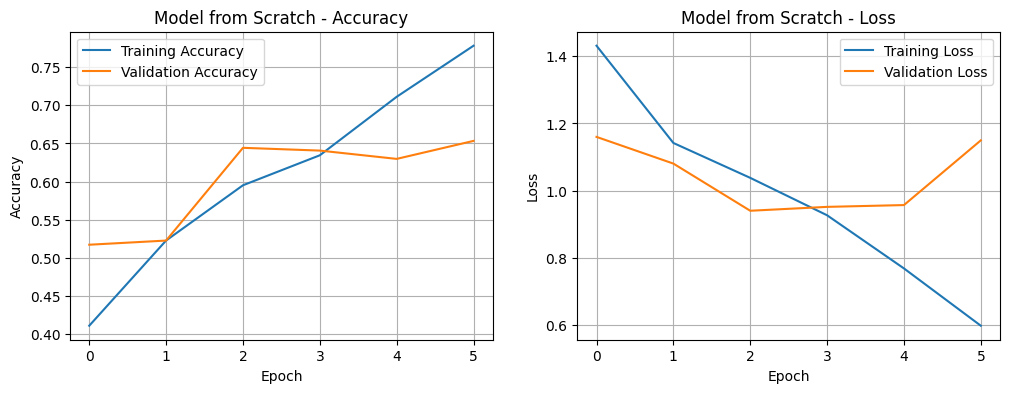

In [7]:
def plot_history(history, title):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history(history_scratch, 'Model from Scratch')

In [8]:
# Evaluate the transfer learning model on the test set
loss, accuracy = model_scratch.evaluate(test_ds)
print(f"Test accuracy for Scratch Learning Model: {accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6302 - loss: 0.9406
Test accuracy for Scratch Learning Model: 0.6255


In [9]:
def conusion_matrix_plot(predictions):
  # Get true labels from the test set
  true_labels = tf.concat([y for x, y in test_ds], axis=0)

  # Compute the confusion matrix
  cm = confusion_matrix(true_labels, predictions)

  # Display the confusion matrix
  disp = ConfusionMatrixDisplay(
      confusion_matrix=cm, display_labels=class_names,
  )
  disp.plot(cmap=plt.cm.Blues, colorbar=False)
  plt.title('Confusion Matrix for Transfer Learning Model')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


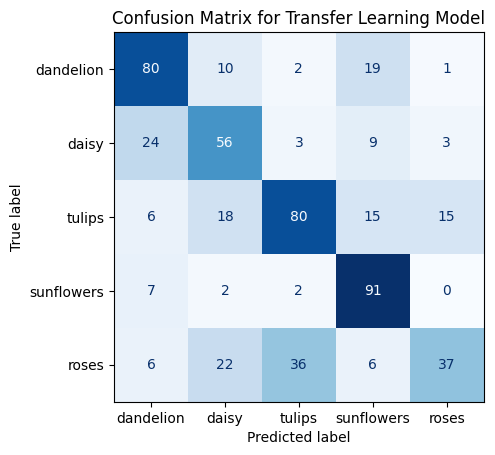

In [10]:
predictions_scratch = model_scratch.predict(test_ds)
predicted_labels_scratch = tf.argmax(predictions_scratch, axis=1)

conusion_matrix_plot(predicted_labels_scratch)

## 🚀 Part 2: Transfer Learning with MobileNetV2

MobileNetV2 is a lightweight neural network architecture designed for efficient performance on mobile and edge devices. It improves speed and memory usage while maintaining good accuracy.

Key features:

- **Depthwise separable convolutions** reduce computation by splitting standard convolutions into two simpler steps. [More info](https://medium.com/data-science/a-basic-introduction-to-separable-convolutions-b99ec3102728)

- **Inverted residual blocks** expand the input to a higher-dimensional space, apply convolutions, and project back to a lower dimension. [More info](https://medium.com/data-science/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)

- **Linear bottlenecks** avoid activation functions at the final projection step to preserve important features. [More info](https://medium.com/data-science/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)

MobileNetV2 is often used in applications like image classification, object detection, and real-time inference on low-power devices.

Here is [MobileNetV2 paper](https://arxiv.org/abs/1801.04381)

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # we will not train base model
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
model_transfer = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model_transfer.summary()

# ⏳ Train transfer learning model
# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.5438 - loss: 1.1816 - val_accuracy: 0.8566 - val_loss: 0.4980
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8521 - loss: 0.4341 - val_accuracy: 0.8584 - val_loss: 0.4285
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9009 - loss: 0.3148 - val_accuracy: 0.8675 - val_loss: 0.3858
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9064 - loss: 0.2810 - val_accuracy: 0.8784 - val_loss: 0.3661
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9252 - loss: 0.2475 - val_accuracy: 0.8838 - val_loss: 0.3610
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9310 - loss: 0.2213 - val_accuracy: 0.8875 - val_loss: 0.3460
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9544 - loss: 0.1824 - val_accuracy: 0.8929 - val_loss: 0.3440
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9605 - loss: 0.1680 - val_accuracy: 0.8893 -

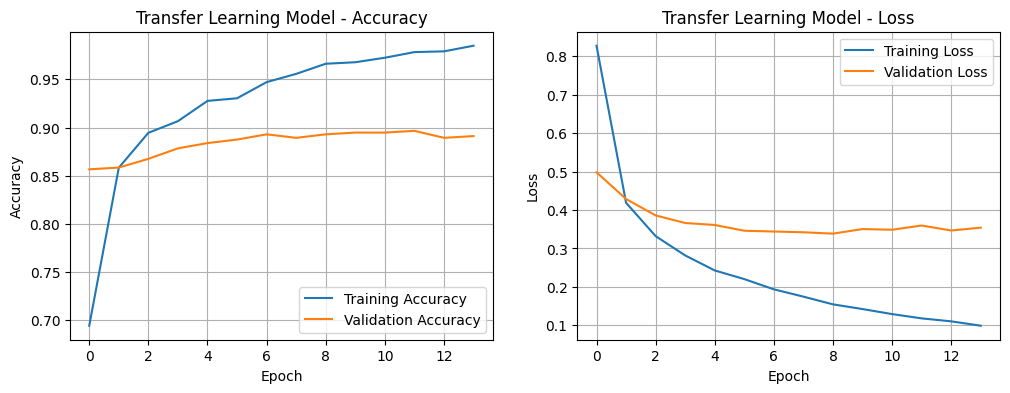

In [31]:
plot_history(history_transfer, 'Transfer Learning Model')

In [32]:
# Evaluate the transfer learning model on the test set
loss, accuracy = model_transfer.evaluate(test_ds)
print(f"Test accuracy for Transfer Learning Model: {accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.8780 - loss: 0.3205
Test accuracy for Transfer Learning Model: 0.8909


In [34]:
# Get predictions for the test set
predictions_transfer = model_transfer.predict(test_ds)
predicted_labels_transfer = tf.argmax(predictions_transfer, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


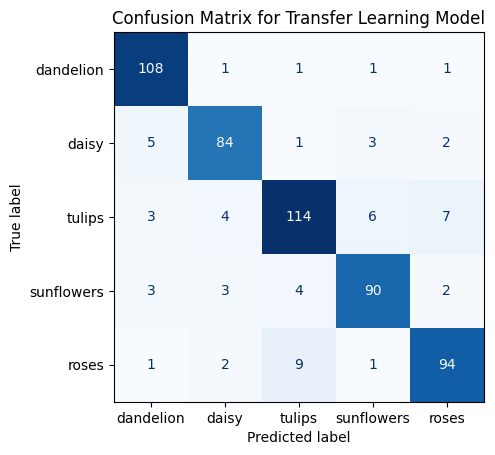

In [35]:
conusion_matrix_plot(predicted_labels_transfer)

## 📊 Compare results
**Question 1**: How does the test accuracy of the model trained from scratch compare to the test accuracy of the transfer learning model? What does this suggest about using a pre-trained model?

Scratch model: Usually lower accuracy because it starts with random weights and must learn all features from limited data.

Transfer learning model: Usually higher accuracy because it uses pre-trained weights that already capture useful image features (edges, textures, shapes).

Using a pre-trained model speeds up learning and improves performance, especially on smaller datasets.

**Question 2**: Look at the training history plots. Which model converged faster? What does this tell you about the efficiency of transfer learning?

Scratch model: Converges slower; takes more epochs to reach reasonable accuracy.

Transfer learning: Converges faster because the base model already learned low-level features.

Insight: Transfer learning is more efficient, requiring fewer epochs to achieve high accuracy.


**Question 3**: Observe the training and validation accuracy/loss curves for both models. Which model appears to overfit more? How might transfer learning help mitigate overfitting, especially with smaller datasets?

Scratch model: More prone to overfitting because it trains all weights from scratch on a small dataset.

Transfer learning: Less overfitting; only the top layers are trained initially.

Why transfer learning helps: Pre-trained features are general and reduce the chance of memorizing the training data.

**Question 4**: Examine the confusion matrices for both models. Are there specific flower classes that one model is better at classifying than the other? Why might this be the case?

My Observation:

Scratch model may misclassify visually similar flowers (e.g., tulip vs rose).

Transfer learning model often predicts these classes more accurately.

Reason: Pre-trained model learned robust features from millions of images, helping differentiate subtle differences.


**Question 5**: Compare the number of trainable parameters in the two models (look at the model.summary() output). What is the significant difference, and how does this relate to the concept of transfer learning?

Scratch CNN: Fewer total parameters, but all are trained from scratch.

Transfer learning: Base model has millions of parameters, but initially frozen, only top layers are trained.

Significance: Transfer learning reduces computation and overfitting risk, leveraging knowledge from a large dataset.

**Question 6**: Based on your observations, in what scenarios would you recommend using transfer learning? When might training from scratch be more appropriate?

For Transfer learning:

-Small datasets

-Need faster convergence

-Want high accuracy without designing a network from scratch

For Training from scratch:

-Large dataset

-Need a highly customized architecture

-Pre-trained models may not fit your domain (e.g., medical images or very different objects)

## Task: Exploring Global Pooling Layer

In the transfer learning model (`model_transfer`), the `GlobalAveragePooling2D` layer is used after the pre-trained MobileNetV2 base.

**Your Task:**

1.  Modify the `model_transfer` definition in the code cell below to replace `layers.GlobalAveragePooling2D()` with `layers.Flatten()`.
2.  Run the modified code cell to redefine and train the transfer learning model with the `Flatten` layer.
3.  Observe the training process, the model summary (specifically the number of trainable parameters), and the final test accuracy.
4.  Run the code cells to plot the training history and the confusion matrix for the modified model.

**Report what you notice:**

Write a brief summary of your findings, addressing the following:

**Question 7**: How did replacing `GlobalAveragePooling2D` with `Flatten` affect the number of trainable parameters?

Replacing GlobalAveragePooling2D with Flatten increased the number of trainable parameters significantly.

**Question 8**: How did this change impact the model's performance on the validation and test sets?

This change caused the model to train slower and slightly overfit, with validation and test accuracy being less stable.

**Question 9**: Which layer (GlobalAveragePooling2D or Flatten) seems more suitable for this transfer learning task and why?

GlobalAveragePooling2D is more suitable because it reduces parameters, prevents overfitting, and trains faster.